<a href="https://colab.research.google.com/github/senguptashritama/Multilabel-Classification-of-ResearchPapers/blob/main/RF_MultiOutputClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading required libraries and preprocessed dataset

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
! pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive (4)/filtered_data.csv")
df.head()

,titles,summaries,terms
0,survey semantic stereo match semantic depth ...,stereo match one widely use technique infer de...,"['cs.CV', 'cs.LG']"
1,futureai guide principle consensus recommend...,recent advancement artificial intelligence a...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,enforce mutual consistency hard region semisup...,paper propose novel mutual consistency netwo...,"['cs.CV', 'cs.AI']"
3,parameter decoupling strategy semisupervise 3d...,consistency training prove advanced semisuperv...,['cs.CV']
4,backgroundforeground segmentation interior sen...,ensure safety automate drive correct percept...,"['cs.CV', 'cs.LG']"


### Creating word embedding of the input text (titles and summaries) using Word2Vec

In [ ]:
df['text'] = df['titles'] + ' ' + df['summaries']

df['tokens'] = df['text'].apply(word_tokenize)
model = Word2Vec(sentences= df['tokens'], vector_size=100, window=5, min_count=1, sg=0)
model.save("word2vec_arxiv.model")

In [ ]:
word2vec_model = Word2Vec.load("word2vec_arxiv.model")

def text_to_vectors(text, word2vec_model):
    words = text.split()
    vector = np.zeros(word2vec_model.vector_size)
    for word in words:
        if word in word2vec_model.wv:
            vector += word2vec_model.wv[word]
    if np.count_nonzero(vector) == 0:
        return vector
    else:
        return vector / np.linalg.norm(vector)

df["titles"] = df["titles"].apply(lambda x: text_to_vectors(x, word2vec_model))
df["summaries"] = df["summaries"].apply(lambda x: text_to_vectors(x, word2vec_model))

In [ ]:
df.head()

,titles,summaries,terms,text,tokens
0,"[0.013574243443540721, 0.07708918240275044, 0....","[0.030916585338196533, 0.09602040885164129, 0....","[cs.CV, cs.LG]",survey semantic stereo match semantic depth ...,"[survey, semantic, stereo, match, semantic, de..."
1,"[0.033446119344201594, 0.06236873972524802, -0...","[0.05727361606840317, 0.06519551909021894, -0....","[cs.CV, cs.AI, cs.LG]",futureai guide principle consensus recommend...,"[futureai, guide, principle, consensus, recomm..."
2,"[0.06542501272223201, 0.13950005684695133, 0.1...","[0.145687038525565, 0.20666576632670872, 0.007...","[cs.CV, cs.AI]",enforce mutual consistency hard region semisup...,"[enforce, mutual, consistency, hard, region, s..."
3,"[0.17026970542679618, 0.15157656237166134, -0....","[0.11560829412707188, 0.23296832022850134, 0.0...",[cs.CV],parameter decoupling strategy semisupervise 3d...,"[parameter, decoupling, strategy, semisupervis..."
4,"[0.12073854857808855, 0.00019836864067747278, ...","[0.16229060603283255, 0.12950841002963429, -0....","[cs.CV, cs.LG]",backgroundforeground segmentation interior sen...,"[backgroundforeground, segmentation, interior,..."


### Encoding target variable using MultilabelBinarizer

In [ ]:
df['terms'] = df['terms'].str.replace("'", "")

In [ ]:
terms_split = df['terms'].str.strip('][').str.split(', ')
mlb = MultiLabelBinarizer()
y_encoded = pd.DataFrame(mlb.fit_transform(terms_split), columns=mlb.classes_)


print(mlb.classes_)

['cs.AI' 'cs.CV' 'cs.LG' 'eess.IV' 'stat.ML']


### Merging the encoded columns to one dataframe

In [ ]:
combined_data = pd.concat([df, y_encoded], axis=1)

### Preparing predictor variables (X) and target variables (Y) for model training

In [ ]:
x_data = combined_data[['titles','summaries']].values
X =  np.array(x_data.tolist())
X = X.reshape(X.shape[0], -1)

In [ ]:
y_data = combined_data[['cs.AI','cs.CV','cs.LG','eess.IV','stat.ML']].values
y =  np.array(y_data.tolist())

In [ ]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Calculating costs based on class frequencies

In [ ]:
class_frequencies = y_train.mean(axis=0)
label_costs = 1 / class_frequencies

sample_weights = np.array([label_costs[label] for label in np.argmax(y_train, axis=1)])

### Model Training

Utilized a RandomForestClassifier from scikit-learn, then employed MultiOutputClassifier to handle multi-label classification tasks, assigning custom sample weights based on label costs for improved model training.

In [ ]:
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model = MultiOutputClassifier(base_classifier, n_jobs=-1)
rf_model.fit(X_train, y_train, sample_weight=sample_weights)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
label_mapping = {0: 'cs.AI', 1: 'cs.CV', 2: 'cs.LG', 3: 'eess.IV', 4: 'stats.ML'}

for i in range(min(20, y_test.shape[0])):
    actual_labels = [label_mapping[j] for j in range(y_test.shape[1]) if y_test[i, j] == 1]
    predicted_labels = [label_mapping[j] for j in range(y_pred.shape[1]) if y_pred[i, j] == 1]
    print("Sample", i+1)
    print("Actual Labels:", actual_labels)
    print("Predicted Labels:", predicted_labels)
    print()

Sample 1
Actual Labels: ['cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG']

Sample 2
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 3
Actual Labels: ['cs.AI', 'cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 4
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 5
Actual Labels: ['cs.CV', 'eess.IV']
Predicted Labels: ['cs.CV']

Sample 6
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 7
Actual Labels: ['cs.LG']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 8
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 9
Actual Labels: ['cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 10
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 11
Actual Labels: ['cs.CV', 'cs.LG']
Predicted Labels: ['cs.CV']

Sample 12
Actual Labels: ['cs.CV', 'cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 13
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 14
Actual Labels: ['cs.AI', 'cs.LG',

We can see that the model can capture maximum upto 2 labels and not more just like SVC.

### Model Evaluation

1) ROC Curve

2) Balanced overall accuracy and F1 score

3) Confusion matrix for each label

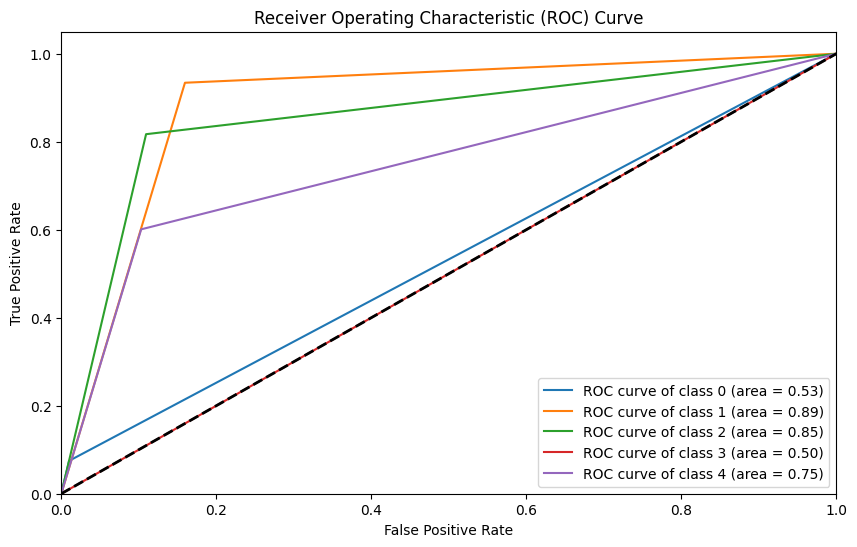

In [ ]:
# Step 1: Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 2: Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_true contains true labels and y_pred contains predicted labels

# Compute balanced accuracy score for each label
balanced_acc_scores = []
for i in range(y_test.shape[1]):
    balanced_acc_scores.append(accuracy_score(y_test[:, i], y_pred[:, i]))

# Compute average balanced accuracy score
average_balanced_acc_score = np.mean(balanced_acc_scores)

print("Average Balanced Accuracy Score:", average_balanced_acc_score)

Average Balanced Accuracy Score: 0.8759659695143567


In [ ]:
from sklearn.metrics import f1_score

# Compute F1 score for each label
f1_scores = []
for i in range(y_test.shape[1]):
    f1_scores.append(f1_score(y_test[:, i], y_pred[:, i]))

# Compute average F1 score
average_f1_score = np.mean(f1_scores)

print("Average F1 Score:", average_f1_score)

Average F1 Score: 0.5099636484689146


In [ ]:
from sklearn.metrics import confusion_matrix

# Initialize variables to store the confusion matrices
conf_matrices = []

# Compute confusion matrix for each label
for i in range(y_test.shape[1]):
    conf_matrices.append(confusion_matrix(y_test[:, i], y_pred[:, i]))

# Print confusion matrices
for i, conf_matrix in enumerate(conf_matrices):
    print("Confusion Matrix for Label", i)
    print(conf_matrix)

# Compute TP, FP, TN, FN for each label
for i, conf_matrix in enumerate(conf_matrices):
    tn, fp, fn, tp = conf_matrix.ravel()
    print("For Label", i)
    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print()


Confusion Matrix for Label 0
[[4830   49]
 [ 706   57]]
Confusion Matrix for Label 1
[[1722  327]
 [ 237 3356]]
Confusion Matrix for Label 2
[[2507  308]
 [ 517 2310]]
Confusion Matrix for Label 3
[[5350    0]
 [ 292    0]]
Confusion Matrix for Label 4
[[3602  414]
 [ 649  977]]
For Label 0
True Positives (TP): 57
False Positives (FP): 49
True Negatives (TN): 4830
False Negatives (FN): 706

For Label 1
True Positives (TP): 3356
False Positives (FP): 327
True Negatives (TN): 1722
False Negatives (FN): 237

For Label 2
True Positives (TP): 2310
False Positives (FP): 308
True Negatives (TN): 2507
False Negatives (FN): 517

For Label 3
True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 5350
False Negatives (FN): 292

For Label 4
True Positives (TP): 977
False Positives (FP): 414
True Negatives (TN): 3602
False Negatives (FN): 649



 The model appears to perform reasonably well. With a test accuracy of approximately 78.55%, it demonstrates a decent ability to correctly classify instances. The weighted precision, recall, and F1-score also indicate that the model maintains a good balance between correctly identifying positive and negative instances across different classes.